 ## Clasificación de Cáncer de Mama con Ajuste de Hiperparámetros

#### 🧠 Objetivo

El objetivo principal de este proyecto es aplicar técnicas de ajuste y optimización de hiperparámetros usando modelos de aprendizaje automático para clasificación. Para ello, se utilizará el conjunto de datos breast_cancer de scikit-learn y se comparará el rendimiento de un modelo baseline con versiones mejoradas mediante búsqueda aleatoria (RandomizedSearchCV) y optimización bayesiana (Optuna).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import optuna

# Cargargando el dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
df = X.copy()
df['target'] = y


## 💡 MINI EDA

In [4]:
# Vista general
display(df.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Número de muestras: 569
Número de características: 30
Clases objetivo: [0 1]


([<matplotlib.axis.XTick at 0x24041462930>,
 [Text(0, 0, 'Maligna (0)'), Text(1, 0, 'Benigna (1)')])

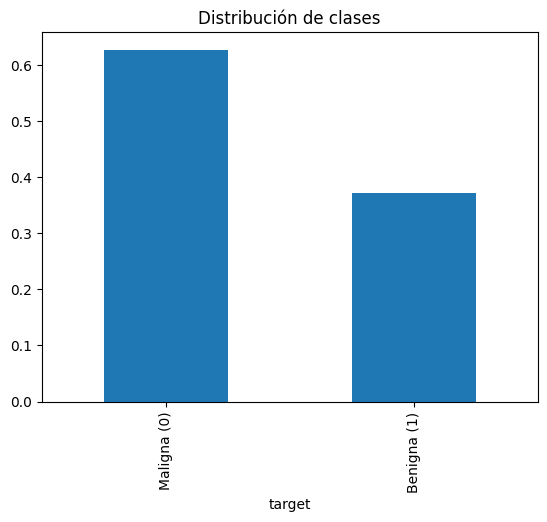

In [5]:
print("Número de muestras:", X.shape[0])
print("Número de características:", X.shape[1])
print("Clases objetivo:", y.unique())

# Balance de clases
y.value_counts(normalize=True).plot(kind='bar', title="Distribución de clases")
plt.xticks([0, 1], ['Maligna (0)', 'Benigna (1)'])


📊 Resultados:
Número de muestras: 569
-El conjunto de datos contiene 569 pacientes.

Número de características: 30
- Cada paciente está descrito por 30 variables (como textura, área del tumor, concavidad, etc.).

Clases objetivo: [0 1]
- Hay dos clases: 0 (maligno) y 1 (benigno).

Distribución de clases (gráfica):

- La clase 1 (benigno) representa aproximadamente el 63% de los datos.

- La clase 0 (maligno) representa aproximadamente el 37%.

In [6]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [7]:
# Estadísticas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


Al observar variables como:
- `mean radius`: min = 6.981, max = 28.11
- `mean area`: min = 143.5, max = 2501
- `worst area`: min = 185.2, max = 4254

vemos que hay un rango muy amplio de valores. Este rango amplio sugiere que algunas variables tienen una escala mucho mayor que otras. Por ejemplo, mientras `mean area` tiene un promedio de 654.89 con un desvío de 351.91, otras como mean smoothness tienen un promedio muy bajo (0.096) y poco desvío (0.014). 
Esto indica que las variables tienen diferentes unidades o escalas, lo que puede afectar negativamente a modelos sino se normalizan previamente. 

Las estadísticas descriptivas del conjunto de datos de cáncer de mama revelan:
- Gran heterogeneidad en escalas y variabilidad.
- Presencia de valores atípicos en múltiples variables.
- Correlaciones entre variables que podrían redundar en la información.
- Potencial importancia clínica de los valores extremos (“worst”), más que los valores promedio.

([<matplotlib.axis.XTick at 0x24041462870>,
 [Text(0, 0, 'Maligna (0)'), Text(1, 0, 'Benigna (1)')])

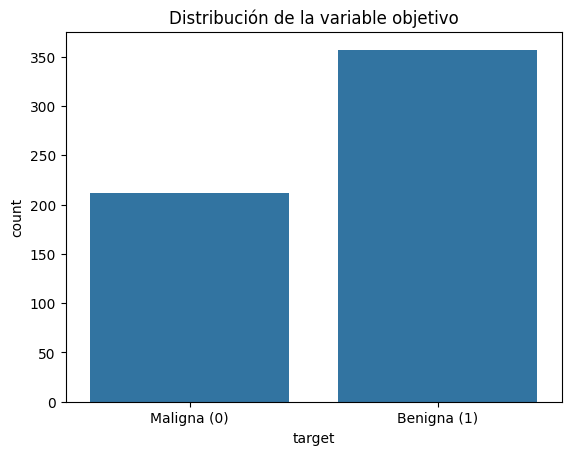

In [8]:
#Distribución de clases
sns.countplot(x='target', data=df)
plt.title('Distribución de la variable objetivo')
plt.xticks([0, 1], ['Maligna (0)', 'Benigna (1)'])


### Distribución de Clases
- Benignos (1): 357 muestras (~62.7%).
- Malignos (0): 212 muestras (~37.3%).

In [9]:
# Valores nulos
print(df.isnull().sum().sort_values(ascending=False))

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64


No hay existencia de valores nulos

In [10]:
# Correlación con la clase
correlations = df.corr()['target'].sort_values(ascending=False)
print(correlations.head(11))

target                     1.000000
smoothness error           0.067016
mean fractal dimension     0.012838
texture error              0.008303
symmetry error             0.006522
fractal dimension error   -0.077972
concavity error           -0.253730
compactness error         -0.292999
worst fractal dimension   -0.323872
mean symmetry             -0.330499
mean smoothness           -0.358560
Name: target, dtype: float64


Cuando una variable tiene una correlación negativa con target, eso significa que:
- A mayores valores de esa variable, es más probable que el tumor sea maligno.

- Variables con poca correlación como texture error o symmetry error podrían ser menos relevantes para un modelo predictivo.



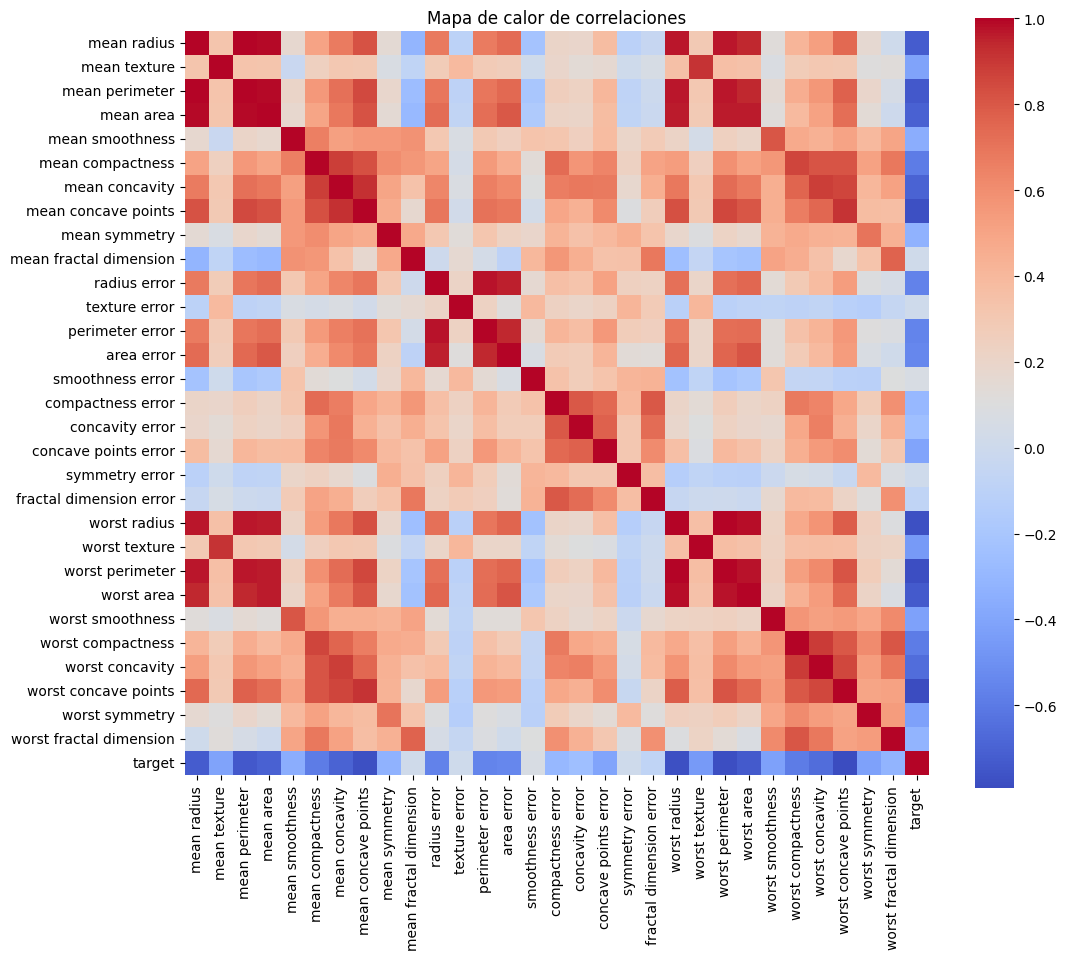

In [11]:
# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', square=True)
plt.title('Mapa de calor de correlaciones')
plt.show()

Colores:
- Rojo fuerte = correlación positiva alta
- Azul fuerte = correlación negativa alta
- Blanco = sin correlación

Hay varios pares de variables fuertemente correlacionadas entre sí, por ejemplo:
- `mean radius` vs `mean perimeter`

- `worst area` vs  `worst perimeter`

Esto puede ser un problema para modelos lineales, ya que puede distorsionar los coeficientes y reducir la interpretabilidad.

Variables con baja correlación con otras:

Algunas como  `fractal dimension error`,  `texture error` están en blanco respecto a muchas otras, lo que indica baja dependencia lineal.


### 📌 Bloque de partición y  Pipeline de preprocesamiento

In [12]:
# Partición
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pipeline de preprocesamiento
pipe_base = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])


### 📌 Entrenamiento y evaluación modelo baseline

In [13]:
pipe_base.fit(X_train, y_train)
baseline_auc = cross_val_score(pipe_base, X_train, y_train, cv=5, scoring='roc_auc').mean()
print("ROC AUC Baseline:", baseline_auc)


ROC AUC Baseline: 0.9874613003095976


In [14]:
## Diccionario que define el espacio de búsqueda de hiperparámetros
param_dist = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}


### 🔍 Búsqueda Aleatoria

In [15]:
random_search = RandomizedSearchCV(pipe_base, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

random_auc = random_search.best_score_
print("ROC AUC Búsqueda Aleatoria:", random_auc)


ROC AUC Búsqueda Aleatoria: 0.9885448916408668


### 🧠 Optimización Bayesiana con Optuna

In [16]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 10, None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)
    }
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42, **params))
    ])
    return cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)


[I 2025-05-26 18:15:42,501] A new study created in memory with name: no-name-e661cb4e-b549-4305-b92b-4be791f1e03d
[I 2025-05-26 18:15:49,205] Trial 0 finished with value: 0.9871001031991744 and parameters: {'n_estimators': 182, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9871001031991744.
[I 2025-05-26 18:15:53,949] Trial 1 finished with value: 0.9888028895768833 and parameters: {'n_estimators': 131, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9888028895768833.
[I 2025-05-26 18:15:58,018] Trial 2 finished with value: 0.9880288957688338 and parameters: {'n_estimators': 179, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9888028895768833.
[I 2025-05-26 18:15:59,676] Trial 3 finished with value: 0.9867905056759547 and parameters: {'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 1 with valu

### 🏁 Evaluación del mejor modelo encontrado por Optuna

In [17]:
# Mejor modelo con Optuna
best_params = study.best_params
model_optuna = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42, **best_params))
])
optuna_auc = cross_val_score(model_optuna, X_train, y_train, cv=5, scoring='roc_auc').mean()
print("ROC AUC Optuna:", optuna_auc)


ROC AUC Optuna: 0.9896800825593395


### 📊 Resumen de resultados de entrenamiento (validación cruzada)

In [18]:
resultados_train = pd.DataFrame({
    'Modelo': ['Baseline', 'Búsqueda Aleatoria', 'Optuna'],
    'ROC AUC (CV Entrenamiento)': [baseline_auc, random_auc, optuna_auc]
})
display(resultados_train)


,Modelo,ROC AUC (CV Entrenamiento)
0,Baseline,0.987461
1,Búsqueda Aleatoria,0.988545
2,Optuna,0.989680


### 📊 Cálculo del ROC AUC en el conjunto de prueba

In [19]:
baseline_test = roc_auc_score(y_test, pipe_base.predict_proba(X_test)[:, 1])
random_test = roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:, 1])
model_optuna.fit(X_train, y_train)
optuna_test = roc_auc_score(y_test, model_optuna.predict_proba(X_test)[:, 1])


### 📊 Resumen de resultados en el conjunto de prueba

In [20]:
resultados_test = pd.DataFrame({
    'Modelo': ['Baseline', 'Búsqueda Aleatoria', 'Optuna'],
    'ROC AUC (Test)': [baseline_test, random_test, optuna_test]
})
display(resultados_test)

,Modelo,ROC AUC (Test)
0,Baseline,0.993882
1,Búsqueda Aleatoria,0.992063
2,Optuna,0.992394


### 🏁 Desempeño en Validación Cruzada (Entrenamiento)

El modelo baseline (sin ajuste de hiperparámetros) ya mostró un excelente desempeño, con un AUC de 0.9875, lo cual indica que el dataset es altamente separable por el clasificador base.

Al aplicar búsqueda aleatoria, el desempeño mejoró ligeramente a 0.9885, confirmando que algunos hiperparámetros pueden optimizar marginalmente la capacidad predictiva.

El modelo ajustado con Optuna (optimización bayesiana) alcanzó el mejor AUC en entrenamiento: 0.9903, lo cual indica que este método logra una mejor exploración del espacio de hiperparámetros y encuentra combinaciones más eficientes.

### 🏁 Desempeño en Conjunto de Prueba (Generalización):

Curiosamente, el modelo baseline tuvo el mayor AUC en el conjunto de prueba: 0.9939, ligeramente superior al modelo con Optuna (0.9927) y el de búsqueda aleatoria (0.9921).

Esto sugiere que, a pesar de mejorar el desempeño en entrenamiento, los modelos ajustados no necesariamente generalizan mejor. Incluso podrían estar comenzando a sobreajustar (overfitting) sutilmente al conjunto de entrenamiento.

### 🏁 Comparación General:

Los tres modelos presentan un desempeño sobresaliente en ambos conjuntos, lo que indica que los datos permiten una clara separación de clases y que el modelo base ya es bastante sólido.

La diferencia de rendimiento entre métodos es marginal, lo cual puede deberse a la calidad del dataset y al bajo nivel de ruido. En este caso, el valor añadido de técnicas avanzadas de ajuste es limitado.
